In [12]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import h5py
import os
import sys
import datetime
import csv

import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import logging
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

# For visualize input
from torch.utils.tensorboard import SummaryWriter
import io
import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from PIL import Image

class EEGDataset(Dataset):
    '''
    Custom Dataset object for PyTorch to load the dataset
    '''
    def __init__(self, x, y, train, val):
        super(EEGDataset).__init__()
        assert x.shape[0] == y.size
        self.x = x
        self.y = [y[i][0] for i in range(y.size)]
        self.train = train
        self.val = val

    def __getitem__(self,key):
        return (self.x[key], self.y[key])

    def __len__(self):
        return len(self.y)

class Logger():
    '''
    Object controlling how information will be logged
    A logger created globally will be used to log all information
    Create a Logger(mode='debug') to have everything print to the console
    '''
    def __init__(self, mode='log'):
        self.mode = mode
        
    def set_model_save_location(self, model_dir):
        self.model_dir = f"saved-model/{model_dir}"
        if not os.path.isdir(self.model_dir):
            os.mkdir(self.model_dir)
        
    def set_experiment(self, experiment_name):
        self.experiment_name = experiment_name
        log_format = '%(asctime)s %(message)s'
        logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                            format=log_format, datefmt='%m/%d %I:%M:%S %p')
        fh = logging.FileHandler(os.path.join('training-logs', f'log-{experiment_name}-{datetime.datetime.today()}.txt'))
        fh.setFormatter(logging.Formatter(log_format))
        logging.getLogger().addHandler(fh)
        self.writer = SummaryWriter(f"runs/{experiment_name}")
            
    def log(self, message=""):
        if self.mode == 'log':
            logging.info(message)
        elif self.mode == 'debug':
            print(message)

    def save_model(self, model, info):
        torch.save(model.state_dict(), f"{self.model_dir}/model-{logger.experiment_name}-{info}")
        
def load_data(path, role, winLength, numChan, srate, feature, one_channel=False, version=""):
    """
    Load dataset
    :param  
        path: Filepath to the dataset
        role: Role of the dataset. Can be "train", "val", or "test"
        winLength: Length of time window. Can be 2 or 15
        numChan: Number of channels. Can be 24 or 128
        srate: Sampling rate. Supporting 126Hz
        feature: Input feature. Can be "raw", "spectral", or "topo"
        one_channel: Whether input has 1 or 3 channel in depth dimension. Matters when load topo data as number of input channels 
                are different from original's
        version: Any additional information of the datafile. Will be appended to the file name at the end
    """
    transform = T.Compose([
        T.ToTensor()
    ])
    if version:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    x = f[f'X_{role}']
    if feature == 'raw':
        x = np.transpose(x,(0,2,1))
        x = np.reshape(x,(-1,1,numChan,winLength*srate))
    elif feature == 'topo':
        if one_channel:
            samples = []
            for i in range(x.shape[0]):
                image = x[i]
                b, g, r = image[0,:, :], image[1,:, :], image[2,:, :]
                concat = np.concatenate((b,g,r), axis=1)
                samples.append(concat)
            x = np.stack(samples)
            x = np.reshape(x,(-1,1,x.shape[1],x.shape[2]))
    
    if version:
        f = h5py.File(path + f"child_mind_y_ages_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_y_ages_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    y = f[f'Y_{role}']
   
    return EEGDataset(x, y, role=='train', role=='val')



def plot_to_image_tensor(figure):
    # Save the plot to a PNG in memory.
    figure.savefig('batch.png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    img = Image.open('batch.png')
    trans = transforms.ToPILImage()
    trans1 = transforms.ToTensor()
    image_tensor = trans1(img)
    return image_tensor

def plot_EEG(data, feature, numChan, one_channel=True):
    '''
    Plot EEG sample
    :param
        data: An EEGDataset object
        feature: String - 'raw' or 'topo'
        numChan: Int - number of EEG channels
        one_channel: Bool - Whether input has 1 or 3 channel in depth dimension. Matters when load topo data as number of input channels 
                are different from original's
    '''
    x_data = data[:][0]
    if feature == 'raw':        
        fig = plt.figure(figsize=(80, 80))
        outer = gridspec.GridSpec(8, 8)
        for i in range(64):
            inner = gridspec.GridSpecFromSubplotSpec(numChan, 1,
                            subplot_spec=outer[i])
#             npimg = img[i,:,:,:].numpy()
            npimg = x_data[i,:,:,:]
            npimg = np.reshape(npimg,(24,256))
            yax = None
            for j in range(24):
                ax = plt.Subplot(fig, inner[j])
                ax.plot(range(256),npimg[j,:],'k')
                ax.set_xticks([])
                ax.set_yticks([])
                fig.add_subplot(ax)

        return fig
    else:
        sample = 2
        if one_channel:
            image = np.reshape(x_data[sample], (x_data[sample].shape[1],x_data[sample].shape[2]))
            plt.imshow(image.astype('int32'))
        else:
            plt.imshow(np.transpose(x_data[sample].astype('int32'), (1, 2, 0)))
        plt.show()

In [ ]:
# Load EEG data
path = './data/'
winLength = 2
numChan = 24
srate = 128
feature = 'raw'
one_channel = False

role = 'train'
train_data = load_data(path, role, winLength, numChan, srate, feature, one_channel)
print(f'X_train shape: {len(train_data)}, {train_data[0][0].shape}')
print(f'Y_train shape: {len(train_data)}, {train_data[0][1].shape}')

role = 'val'
val_data = load_data(path, role, winLength, numChan, srate, feature, one_channel)
print(f'X_val shape: {len(val_data)}, {val_data[0][0].shape}')
print(f'Y_val shape: {len(val_data)}, {val_data[0][1].shape}')
#plot_EEG(train_data, feature, numChan, one_channel)

(array([10807., 13317., 13932., 10386.,  7695.,  5994.,  5265.,  2268.,
          907.,   810.]),
 array([ 5.016997 ,  6.7052014,  8.3934058, 10.0816102, 11.7698146,
        13.458019 , 15.1462234, 16.8344278, 18.5226322, 20.2108366,
        21.899041 ]),
 <a list of 10 Patch objects>)

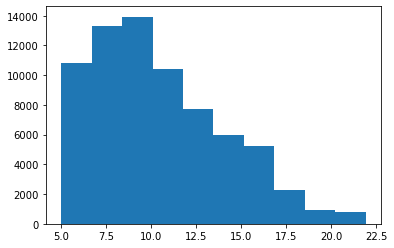

In [3]:
plt.hist(train_data[:][1])

In [4]:
# Initialize device information for PyTorch
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [39]:
def check_accuracy(loader, model):
    '''
    Check accuracy of the model 
    param:
        loader: An EEGDataset object
        model: A PyTorch Module to test
    '''
    if loader.dataset.train:
        logger.log('Checking accuracy on training set')
    elif loader.dataset.val:
        logger.log('Checking accuracy on validation set')
    else:
        logger.log('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    maeloss = nn.L1Loss()
    mseloss = nn.MSELoss()
    with torch.no_grad():
        total_maeloss = 0
        total_mseloss = 0
        total_size = 0
        total_var = 0
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            scores = model(x)
            batch_size = scores.size(0)
            total_size += batch_size
            total_maeloss += maeloss(scores, y)*batch_size
            total_mseloss += mseloss(scores, y)*batch_size
            total_var += torch.var(scores)*batch_size
        logger.log(f"mae={total_maeloss/total_size}, mse={total_mseloss/total_size}, std={torch.sqrt(total_var/total_size)}")
        return total_mseloss/total_size

In [41]:
def train(model, loader_train, loader_val, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    params:
        model: A PyTorch Module giving the model to train.
        loader_train: A PyTorch DataLoader object containing training data loaded in batch
        loader_val: A PyTorch DataLoader object containing validation data loaded in batch        
        optimizer: An Optimizer object we will use to train the model
        epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    maeloss = nn.L1Loss()
    
    def lossfunc(a, b):
        return 1000*maeloss(a, b)
    
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            scores = model(x)
            loss = lossfunc(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                logger.writer.add_scalar("Loss/train", loss.item(), e*len(loader_train)+t)
                logger.log('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
        train_acc = check_accuracy(loader_train, model)
        logger.writer.add_scalar("Acc/train", train_acc, e)        
        val_acc = check_accuracy(loader_val, model)
        logger.writer.add_scalar("Acc/valid", val_acc, e)        
        logger.log()
        
        # Save model every 20 epochs
        if e > 0 and e % 10 == 0:
            logger.save_model(model,f"epoch{e}")
        elif val_acc >= 0.83:
            logger.save_model(model,f"valacc83-epoch{e}")
        elif val_acc >= 0.84:
            logger.save_model(model,f"valacc84-epoch{e}")
    # save final model
    logger.save_model(model,f"epoch{e}")
    return model

In [7]:
def create_model():
    '''
    Create the CNN following configuration in van Putten et al. (2018)
    '''
    model = nn.Sequential(
            nn.Conv2d(1,100,3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(100,100,3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(100,300,(2,3)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(300,300,(1,7)),
            nn.ReLU(),
            nn.MaxPool2d((1,2), stride=1),
            nn.Dropout(0.25),
            nn.Conv2d(300,100,(1,3)),
            nn.ReLU(),
            nn.Conv2d(100,100,(1,3)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1900,6144),
            nn.ReLU(),
            nn.Linear(6144,1),
        )
    return model

In [32]:
# Create and show model summary
model = create_model()
#from pytorch_model_summary import summary
#print(summary(model, torch.zeros((1, 1, 24, 256)), show_input=False))

In [9]:
def test_model(model, test_data, subj_csv):
    '''
    Test model using two different metrics. First is per sample accuracy.
    Second is to use 40 samples per subject and perform voting:
        If mean prediction > 0.5, classify as female (1)
        Otherwise, classify as male (0)
    param:
        model: A trained PyTorch Module
        test_data: test dataset
        subj_csv: spreadsheet containing subject IDs for the test dataset
    '''
    # one-segment test
    logger.log('Testing model accuracy using 1-segment metric')
    loader_test = DataLoader(test_data, batch_size=70)
    per_sample_acc = check_accuracy(loader_test, model)

    # 40-segment test
    logger.log('Testing model accuracy using 40-segment per subject metric')
    with open(subj_csv, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        subjIDs = [row[0] for row in spamreader]
    unique_subjs,indices = np.unique(subjIDs,return_index=True)

    iterable_test_data = list(iter(DataLoader(test_data, batch_size=1)))
    num_correct = []
    for subj,idx in zip(unique_subjs,indices):
    #     print(f'Subj {subj} - gender {iterable_test_data[idx][1]}')
        data = iterable_test_data[idx:idx+40]
        #print(np.sum([y for _,y in data]))
        assert 40 == np.sum([y for _,y in data]) or 0 == np.sum([y for _,y in data])
        preds = []
        correct = 0
        with torch.no_grad():
            for x,y in data:
                x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
                correct = y
                scores = model(x)
                _, pred = scores.max(1)
                preds.append(pred)
        final_pred = (torch.mean(torch.FloatTensor(preds)) > 0.5).sum()
        num_correct.append((final_pred == correct).sum())
    #print(len(num_correct))
    acc = float(np.sum(num_correct)) / len(unique_subjs)
    logger.log('Got %d / %d correct (%.2f)' % (np.sum(num_correct), len(unique_subjs), 100 * acc))
    return per_sample_acc, acc

In [10]:
def run_experiment(seed, model_name, feature, loader_train, loader_val, num_epoch):
    '''
    Train a model for num_epoch given a random seed. 
    During training, logs and intemediary models will be saved in files accordingly to model_name
    param:
        seed: Int - Random seed number
        model_name: String - Name of the model to be saved. Used for logging
        feature: String - Whether 'raw' or 'topo'
        loader_train: DataLoader with training set
        loader_val: DataLoader with validation set
        num_epoch: Int - number of epoch to train the model
    '''
    model = create_model()
    logger.set_model_save_location(f'{model_name}-{feature}')
    experiment = f'{model_name}-{feature}-seed{seed}'
    logger.set_experiment(experiment)

    np.random.seed(seed)
    torch.manual_seed(seed)

    # toggle between learning rate and batch size values 

    optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, weight_decay=0.001)
    model = train(model, loader_train, loader_val, optimizer, epochs=num_epoch)
    
    # Testing
    logger.log('Testing on balanced test set')
    test_data_balanced = load_data(path, 'test', winLength, numChan, srate, feature)
    sample_acc1, subject_acc1 = test_model(model, test_data_balanced, path + 'test_subjIDs_fewer_subjects.csv')

    logger.log('Testing on all-male test set')
    test_data_all_male = load_data(path, 'test', winLength, numChan, srate, feature,'v3')
    sample_acc2, subject_acc2 = test_model(model, test_data_all_male, path + 'test_subjIDs_more_test.csv')
    
    return model

In [40]:
# train model multiple times, each with different random seed
logger = Logger() # initialize logger to be used throughout

batch_size = 128 
loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=batch_size)
for s in range(1):
    model = run_experiment(s, 'original-ages', 'raw',loader_train, loader_val,70)
# model = run_experiment(9, 'original', 'raw',70)

06/06 02:06:19 PM Epoch 0, Iteration 0, loss = 112.1882
06/06 02:06:24 PM Epoch 0, Iteration 100, loss = 45.7138
06/06 02:06:28 PM Epoch 0, Iteration 200, loss = 18.6327
06/06 02:06:33 PM Epoch 0, Iteration 300, loss = 32.1955
06/06 02:06:37 PM Epoch 0, Iteration 400, loss = 29.6340
06/06 02:06:41 PM Epoch 0, Iteration 500, loss = 13.1808
06/06 02:06:44 PM Checking accuracy on training set
06/06 02:06:53 PM mae=3.2792673110961914, mse=16.68598175048828, std=1.9232679605484009
06/06 02:06:53 PM Checking accuracy on validation set
06/06 02:06:58 PM mae=3.2427866458892822, mse=16.476430892944336, std=1.8557953834533691
06/06 02:06:58 PM 
06/06 02:06:58 PM Epoch 1, Iteration 0, loss = 16.7199
06/06 02:07:02 PM Epoch 1, Iteration 100, loss = 22.0496
06/06 02:07:07 PM Epoch 1, Iteration 200, loss = 12.9239
06/06 02:07:11 PM Epoch 1, Iteration 300, loss = 15.3103
06/06 02:07:16 PM Epoch 1, Iteration 400, loss = 22.8410
06/06 02:07:20 PM Epoch 1, Iteration 500, loss = 13.5479
06/06 02:07:23 PM

KeyboardInterrupt: 

In [48]:
torch.std(torch.FloatTensor(val_data.y))

tensor(3.6741)

In [ ]:
# train model multiple times, each with different random seed
logger = Logger() # initialize logger to be used throughout

batch_size = 128 
loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=batch_size)
for s in range(1):
    model = run_experiment(s, 'original-ages', 'raw',loader_train, loader_val,70)
# model = run_experiment(9, 'original', 'raw',70)

06/06 02:17:58 PM Epoch 0, Iteration 0, loss = 10088.3340
06/06 02:18:02 PM Epoch 0, Iteration 100, loss = 2990.9297
06/06 02:18:07 PM Epoch 0, Iteration 200, loss = 2879.7356
06/06 02:18:11 PM Epoch 0, Iteration 300, loss = 3227.3508
06/06 02:18:16 PM Epoch 0, Iteration 400, loss = 3148.2227
06/06 02:18:20 PM Epoch 0, Iteration 500, loss = 2631.7515
06/06 02:18:23 PM Checking accuracy on training set
06/06 02:18:32 PM mae=2.91337251663208, mse=13.438370704650879, std=0.2702169120311737
06/06 02:18:32 PM Checking accuracy on validation set
06/06 02:18:37 PM mae=2.9150209426879883, mse=14.103582382202148, std=0.5781154036521912
06/06 02:18:37 PM 
06/06 02:18:37 PM Epoch 1, Iteration 0, loss = 3165.8420
06/06 02:18:41 PM Epoch 1, Iteration 100, loss = 2883.1428
06/06 02:18:46 PM Epoch 1, Iteration 200, loss = 2910.3538
06/06 02:18:50 PM Epoch 1, Iteration 300, loss = 2981.0310
06/06 02:18:55 PM Epoch 1, Iteration 400, loss = 3108.9094
06/06 02:18:59 PM Epoch 1, Iteration 500, loss = 2529

In [ ]:
def test_all_seeds(partial_model_path, epoch, num_seed, isBalanced=True):
    '''
    Given name of saved model and epoch, check test accuracy for all random seeds in range(num_seed)
    
    '''
    if isBalanced:
        logger.log('Testing on balanced test set')
        test_data = load_data(path, 'test', winLength, numChan, srate, feature,'v2')
        subjIDs_file = 'data/test_subjIDs_fewer_subjects.csv'
    else:
        logger.log('Testing on all male test set')
        test_data = load_data(path, 'test', winLength, numChan, srate, feature,'v3')
        subjIDs_file = 'data/test_subjIDs_more_test.csv'

    sample_acc = []
    subject_acc = []
    for s in range(num_seed):
        model = create_model()
        model.load_state_dict(torch.load(f'{partial_model_path}-seed{s}-epoch{epoch}'))
        model.to(device=device)
        sam_acc, sub_acc = test_model(model, test_data,subjIDs_file)
        sample_acc.append(sam_acc)
        subject_acc.append(sub_acc)
        
    sample_acc = np.multiply(sample_acc,100)
    subject_acc = np.multiply(subject_acc,100)
    return sample_acc, subject_acc

In [ ]:
logger = Logger(mode='debug')
# Compute test performance statistics for all intermidiary saved-models at each specified epochs
# and save result to a csv file
epochs = [40, 50, 60, 69]

with open("original-relu-raw-test-results-balanced.csv", 'w') as out:
    out.write('epoch,min_sam,max_sam,mean_sam,std_sam,min_subj,max_subj,mean_subj,std_subj\n')
    for epoch in epochs:
        sample_acc, subject_acc = test_all_seeds(partial_model_path="saved-model/original-relu-raw/model-original-relu-raw", epoch=epoch, num_seed=10, isBalanced=True)

        min_sample = np.min(sample_acc)
        max_sample = np.max(sample_acc)
        mean_sample = np.mean(sample_acc)
        std_sample = np.std(sample_acc)

        min_subj = np.min(subject_acc)
        max_subj = np.max(subject_acc)
        mean_subj = np.mean(subject_acc)
        std_subj = np.std(subject_acc)

        logger.log("Per sample")
        logger.log(f"Min: {min_sample}, Max: {max_sample}, Mean: {mean_sample}, STDEV: {std_sample}")

        logger.log("Per subject")
        logger.log(f"Min: {min_subj}, Max: {max_subj}, Mean: {mean_subj}, STDEV: {std_subj}")
        out.write(f"{epoch},{min_sample},{max_sample},{mean_sample},{std_sample},{min_subj},{max_subj},{mean_subj},{std_subj}\n")
        